In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(10,15)
import seaborn as sns
sns.set_theme()
import tensorly as tl
import tensorly.decomposition as td
from sklearn.decomposition import TruncatedSVD

import imageio
from PIL import Image
import urllib.request
from tqdm import tqdm

from cairosvg import svg2png

import os,time
from glob import glob

import coloredlogs, logging


In [2]:
# Create a logger object.
logger = logging.getLogger(__name__)
coloredlogs.install(level='ERROR')

In [3]:
df = pd.read_csv('flags_url.csv')
df.head()

country              images_file  \
0  Afghanistan  Flag_of_Afghanistan.svg   
1      Albania      Flag_of_Albania.svg   
2      Algeria      Flag_of_Algeria.svg   
3      Andorra      Flag_of_Andorra.svg   
4       Angola       Flag_of_Angola.svg   

                                           image_url alpha-2 alpha-3  \
0  https://upload.wikimedia.org/wikipedia/commons...      AF     AFG   
1  https://upload.wikimedia.org/wikipedia/commons...      AL     ALB   
2  https://upload.wikimedia.org/wikipedia/commons...      DZ     DZA   
3  https://upload.wikimedia.org/wikipedia/commons...      AD     AND   
4  https://upload.wikimedia.org/wikipedia/commons...      AO     AGO   

   country-code     iso_3166-2  region          sub-region  \
0           4.0  ISO 3166-2:AF    Asia       Southern Asia   
1           8.0  ISO 3166-2:AL  Europe     Southern Europe   
2          12.0  ISO 3166-2:DZ  Africa     Northern Africa   
3          20.0  ISO 3166-2:AD  Europe     Southern Europe   
4          24.0  ISO 3166-2:AO  Africa  Sub-Saharan Africa   

  intermediate-region  region-code  sub-region-code  intermediate-region-code  
0                 NaN        142.0             34.0                       NaN  
1                 NaN        150.0             39.0                       NaN  
2                 NaN          2.0             15.0                       NaN  
3                 NaN        150.0             39.0                       NaN  
4       Middle Africa          2.0            202.0                      17.0

In [4]:
#download all flags
for i in tqdm(range(len(df)),ncols=70, colour='green'):
    code = df.iloc[i]['alpha-2']
    url = df.iloc[i].image_url
    path = f'flags/{code}.svg'
    if(os.path.isfile(path)): continue
    try:
        urllib.request.urlretrieve(url,path)
    except:
        pass

100%|██████████████████████████████| 273/273 [00:00<00:00, 613.77it/s]


In [5]:
for f in tqdm(glob('flags/*.svg'), ncols=70,colour='magenta'):
    pngpath = f.split('.')[0]+'.png'
    try:
        svg2png(url=f, write_to=pngpath)
    except:
        pass

100%|███████████████████████████████| 189/189 [00:11<00:00, 16.31it/s]


In [6]:
def read_flag(countrycode='IN'):
    countrycode = countrycode.upper()
    #url = df[df['alpha-2']==countrycode].image_url
    path = f'flags/{countrycode}.png'
    flag = Image.open(path).convert('RGB').resize((128,64),)
    flag = np.array(flag)
    return flag

In [7]:
flag = read_flag('GB')
flag.shape

(64, 128, 3)

(-0.5, 127.5, 63.5, -0.5)

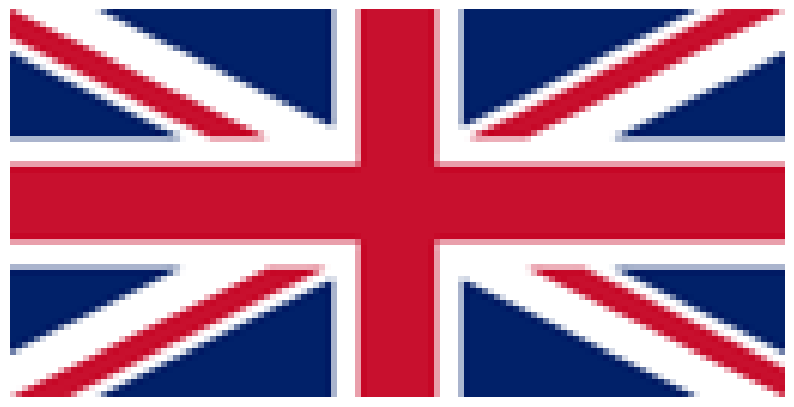

In [8]:
plt.imshow(flag)
plt.axis('off')

In [9]:
def decompose(_FLAG,_RANK):
    #(w,f),e = td.non_negative_parafac(np.array(_FLAG,dtype=float),rank=_RANK, n_iter_max=int(1e4), return_errors=True)
    (w,f),e = td.parafac(np.array(_FLAG,dtype=float),orthogonalise=True,rank=_RANK, n_iter_max=int(1e4), return_errors=True)
    
    #print(f'iters:{len(e)}, error: {e[-1]}')
    
    comps=[]
    for r in range(_RANK):
        a = f[0][:,r]
        b = f[1][:,r]
        c = f[2][:,r]
        
        a/=np.linalg.norm(a)
        b/=np.linalg.norm(b)
        c/=np.linalg.norm(c)
        
        comps.append(np.outer(np.outer(a,b),c).reshape(_FLAG.shape))
    return comps,e[-1]

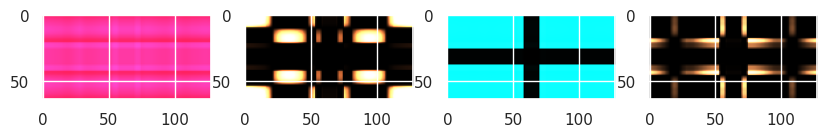

In [10]:
# Example factorization

R=4
flag_decomp,error = decompose(flag,R)

f, axes = plt.subplots(1, R, figsize=(10,15))
for r,ax in enumerate(axes):
    ax.imshow(flag_decomp[r]*255)

In [11]:
# https://www.britannica.com/list/flags-that-look-alike

allpngs = ['Venezuela', 'Ecuador', 'Colombia']
allpngs+= ['Slovenia', 'Russia', 'Slovakia']
allpngs+= ['Luxembourg','Netherlands']
allpngs+= ['Norway','Iceland']
allpngs+= ['New Zealand', 'Australia']
allpngs+= ['Indonesia', 'Monaco']
allpngs+= ['Senegal','Mali']


countries = list(map(lambda x:  df[df.country==x]['alpha-2'].to_list()[0] if df[df.country==x]['alpha-2'].to_list() else '', allpngs))
#countries

In [13]:
features = []
MAX_RANK=7
for c in tqdm(countries, ncols=70, colour='blue'):
    
    __feat_colors=[]
    __feat_factors=[]
    __flag = read_flag(c)
    __flag_normalised = __flag/np.linalg.norm(__flag)
    
    
    for channel in range(3):
        channel_weight = np.linalg.norm(__flag_normalised[:,:,channel])
        __feat_colors.append(channel_weight)
        
    for r in range(1,MAX_RANK):
        factors,e = decompose(__flag,r)
        __feat_factors.append(e)
    
    
    features.append([__feat_colors, __feat_factors])
        

100%|█████████████████████████████████| 16/16 [07:42<00:00, 28.89s/it]


In [ ]:
feat_matrix = np.array(features)
feat_matrix

In [ ]:
svd = TruncatedSVD(n_components=3)
compressed = svd.fit_transform(feat_matrix)
compressed

In [ ]:
sns.scatterplot(x=compressed[:,0], y=compressed[:,1])
for i,c in enumerate(countries):
    codes = df['alpha-2'].to_list()
    names = df['country'].to_list()
    
    plt.text(compressed[i,0], compressed[i,2], names[codes.index(c)], horizontalalignment='left', size='small', color='black', weight='normal')
    #plt.text(compressed[i,1], compressed[i,2], names[codes.index(c)], horizontalalignment='left', size='small', color='black', weight='normal')
